## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import pickle

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import roc_auc_score

import xgboost as xgb

# magic word for producing visualizations in notebook
%matplotlib inline

The cleaning function can be shortend, because the given dataframes are less messy than the ones for the unsupervised learning

In [2]:
def clean_function(df, columns_2drop, drop_double, drop_unique):
    """
    Clean the dataframe
    
    Input:
        columns_2drop: array like sample
        drop_double: array like target relative to X2 sample
        drop_unique: object type that implements the “fit” and “predict” menum_trainings (int): number of training samples to plot
        
    Output:
        modified dataframe
    """
    
    xls_dias = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
    attri_unknown = xls_dias[xls_dias['Meaning']=='unknown'][['Attribute','Value']]
    attri_unknown['Value'] = attri_unknown['Value'].astype(str).str.split(',')
    
    # Change the values from object to numeric
    ind = list(attri_unknown.index)
    num_val = []
    for i in ind:
        num_val.append(pd.to_numeric(attri_unknown['Value'][i]))

    # Choose the columns which are in common
    attri_unknown['Value_new'] = num_val
    attri_unknown = attri_unknown.drop(['Value'], axis=1)
    unknowns = dict(attri_unknown.values)

    #Set the unknowns to NaN
    att_cust = set(mailout_train.columns)
    att_xls = set(unknowns.keys())

    attributes_cust = sorted(att_cust & att_xls)
    # Set all values which are referred to unknown to nan
    for k in attributes_cust:
        unk = unknowns[k]
        df[k] = df[k].replace(unk,np.nan)
    
    col_types = df.dtypes
    col_object = list(col_types[col_types=='object'].index)
    
    
    df[col_object] = df[col_object].replace(['XX','X'], np.nan)
    df['GEBURTSJAHR'] = df['GEBURTSJAHR'].replace(0, np.nan)
    
    mod_df = df.drop(columns_2drop, axis=1)
    mod_df = mod_df.drop(drop_double, axis=1)
    mod_df = mod_df.drop(drop_unique, axis=1)

    mod_df['CAMEO_DEUG_2015'] = pd.to_numeric(mod_df['CAMEO_DEUG_2015']).replace(-1,np.nan).ffill()
    mod_df['OST_WEST_KZ'] = mod_df['OST_WEST_KZ'].replace('W',1).replace('O',0).replace(-1,np.nan).ffill()

    # Change column 'Eingefuegt am'
    mod_df['EINGEFUEGT_AM'] = pd.to_numeric(mod_df['EINGEFUEGT_AM'].str.split('-').str.get(0))
    
    return mod_df

In [60]:
def learning_curves(X, y, estimator, num_trainings):
    """
    Draw learning curve that shows the validation and training auc_score of an estimator 
    for varying numbers of training samples.
    
    Input:
        X: array like sample
        y: array like target relative to X2 sample
        estimator: object type that implements the “fit” and “predict” methods
        num_trainings (int): number of training samples to plot
        
    Output:
        None
    """
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color = 'blue', marker = 'o', markersize=5, label = 'Training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color = 'blue')
    plt.plot(train_sizes, test_mean, color = 'green', linestyle = '--', marker = 's', markersize=5, label = 'Validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')
    
    plt.grid()
    #plt.xscale('log')
    plt.legend(loc='best')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.show()

In [4]:
# Load data
mailout_train = pickle.load(open("mailout_train.p","rb"))
mailout_test = pickle.load(open("mailout_test.p","rb"))

In [5]:
# Check columns for the percentage of missing data
ls = list(mailout_train.columns)
for i in ls:
    x = mailout_train[i].isnull().sum()/len(mailout_train)
    if x > 0.3:
        print(i, x)

AGER_TYP 0.4181136818583865
ALTER_KIND1 0.9537265490433406
ALTER_KIND2 0.982403053861552
ALTER_KIND3 0.9959499092221032
ALTER_KIND4 0.9990456682649783
EXTSEL992 0.37121176853963966
GEBURTSJAHR 0.4067548065732508
KBA05_BAUMAX 0.5348912992877427
KK_KUNDENTYP 0.5892649318001956
TITEL_KZ 0.9950421302546436


Columns with more than 30% of missing data are dropped

In [5]:
# Set the columns which can be droped
columns_2drop = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
drop_double =   ['ALTERSKATEGORIE_FEIN','LP_FAMILIE_FEIN','LP_LEBENSPHASE_FEIN','LP_STATUS_FEIN', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
#drop_double =   ['ALTERSKATEGORIE_GROB','LP_FAMILIE_GROB','LP_LEBENSPHASE_GROB','LP_STATUS_GROB', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
drop_unique =   ['LNR', 'D19_LETZTER_KAUF_BRANCHE']

In [6]:
# Cleaning the dataframe
mailout_train_clean = clean_function(mailout_train, columns_2drop, drop_double, drop_unique)

In [7]:
# Separate the Response column from the dataframe
X = mailout_train_clean.drop(['RESPONSE'], axis=1)
y = mailout_train_clean['RESPONSE']

In [8]:
col_binary = ['DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KBA05_SEG6', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ','UNGLEICHENN_FLAG','VERS_TYP','ANREDE_KZ']
col_continuous = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW']
col_numerical = list(set(X.columns) - set(col_continuous) - set(col_binary))

In [9]:
# binary pipeline
binary_pipeline = Pipeline([('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# continuous pipeline
continuous_pipeline = Pipeline([
    ('log_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log_transform', FunctionTransformer(np.log1p)),
    ('log_scale', StandardScaler())
])

# numerical pipeline
numerical_pipeline = Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
])

In [10]:
# Create a transformer function which applies the pipelines
transformers = [('skewed', continuous_pipeline, col_continuous),
               ('binary', binary_pipeline, col_binary),
               ('numerical', numerical_pipeline, col_numerical)]

column_transformer = ColumnTransformer(transformers = transformers)

In [11]:
# Initialize different Learning Algorithms
models = {'LogisticRegression': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000),
          'RandomForestClassifier': RandomForestClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
         }

LogisticRegression


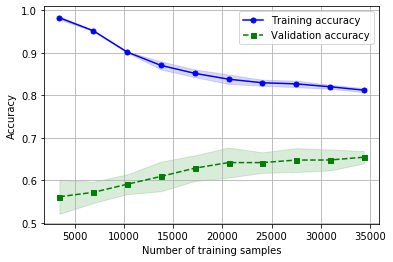

RandomForestClassifier


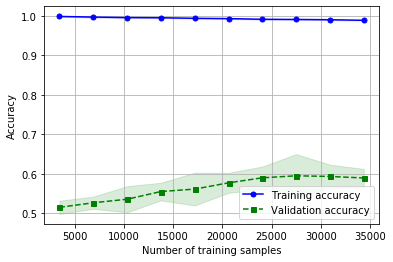

AdaBoostClassifier


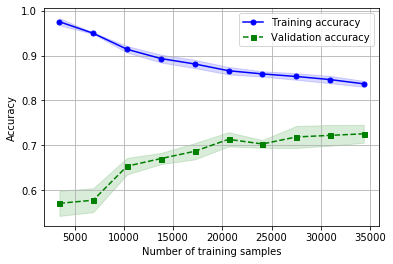

GradientBoostingClassifier


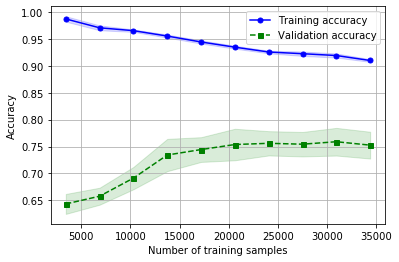

XGBClassifier


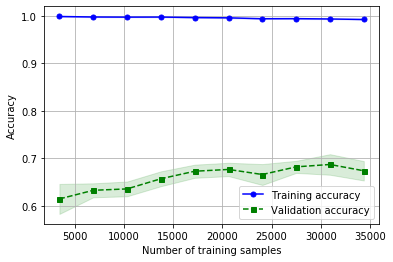

In [61]:
# Create a loop: Each loops performs a different algorithm and plot the training and validation accuracy.
# The reason for that is to choose a model which does not overfit the training data
for model in models.keys():
    print(model)
    ml_pipeline = Pipeline([
        ('transform', column_transformer),
        ('model', models[model])
    ])
    
    learning_curves(X, y, ml_pipeline, 10)

Logistic Regression shows a rather good performance.

The Random Forest Classifier and XGB Classifier seem to be highly overfitted.

The AdaBoost and Gradient Boosting Classifier both show good performance

In [15]:
# Get the hyperparameters for each estimator
for model in models.keys():
    print(model)
    print(models[model].get_params().keys())

LogisticRegression
dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])
RandomForestClassifier
dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
AdaBoostClassifier
dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])
GradientBoostingClassifier
dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 

In [114]:
# Defining the Hyperparameters for the Grid Search of the Gradient Boosting Classifier
parameters = {'gbc__learning_rate': [0.1, 0.2], 'gbc__n_estimators': [100],
            'gbc__max_depth': [3, 5], 'gbc__min_samples_split': [2, 4]}

In [115]:
# Defining the Hyperparameters for the Grid Search of the AdaBoost Classifier
#parameters = {'abc__n_estimators': [50, 100],
 #             'abc__learning_rate' : [0.01,0.05,0.1,0.3,1]}

In [116]:
# Initialize the Gradient Boosting pipeline
pipe_gbc = Pipeline([
    ('transform', column_transformer),
    ('gbc', GradientBoostingClassifier())
])

# Perform the GridSearch to find the optimal hyperparameters
grid_obj = GridSearchCV(pipe_gbc, parameters, scoring = 'roc_auc', verbose=50)

grid_obj.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 1/5; 1/8] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.723 total time=  46.6s
[CV 2/5; 1/8] START gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 2/5; 1/8] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.737 total time=  46.3s
[CV 3/5; 1/8] START gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 3/5; 1/8] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.796 total time=  46.5s
[CV 4/5; 1/8] START gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 4/5; 1/8] END gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_

[CV 3/5; 7/8] END gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.719 total time= 1.3min
[CV 4/5; 7/8] START gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 4/5; 7/8] END gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.713 total time= 1.3min
[CV 5/5; 7/8] START gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=2, gbc__n_estimators=100
[CV 5/5; 7/8] END gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=2, gbc__n_estimators=100;, score=0.705 total time= 1.3min
[CV 1/5; 8/8] START gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=4, gbc__n_estimators=100
[CV 1/5; 8/8] END gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=4, gbc__n_estimators=100;, score=0.656 total time= 1.3min
[CV 2/5; 8/8] START gbc__learning_rate=0.2, gbc__max_depth=5, gbc__min_samples_split=4, gbc__n_estimators=

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('skewed',
                                                                         Pipeline(steps=[('log_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log_transform',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('log_scale',
                                                                                          StandardScaler())]),
                                                                         ['ANZ_HAUSHALTE_AKTIV',
                                                                          'ANZ_HH_T

In [117]:
# Make predictions with the optimized model
print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X)[:, 1]

# Make predictions using unoptimized
predictions = (pipe_gbc.fit(X, y)).predict_proba(X)[:, 1]

# Compare the improvement of the grid search
print("ROC AUC score: {:.4f}".format(roc_auc_score(y, predictions)))
print("Final ROC AUC score: {:.4f}".format(roc_auc_score(y, best_predictions)))

{'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__min_samples_split': 2, 'gbc__n_estimators': 100}
ROC AUC score: 0.8976
Final ROC AUC score: 0.8976


In [118]:
best_clf = pipe_gbc.fit(X, y)

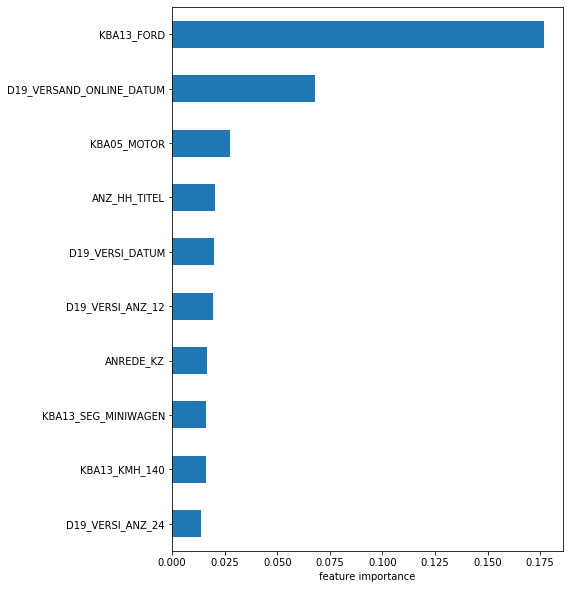

In [119]:
feature_importances = best_clf.named_steps['gbc'].feature_importances_

pd.Series(feature_importances,  index=[''] + X.columns).sort_values()[-10:].plot(kind='barh', figsize=(7,10))
plt.xlabel('feature importance')
plt.savefig('feature_importance.png', dpi=500);

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [120]:
mailout_test_clean = clean_function(mailout_test, columns_2drop, drop_double, drop_unique)

In [121]:
kaggle_predict = best_clf.predict_proba(mailout_test_clean)[:,1]

In [122]:
kaggle_predict.shape

(42833,)

In [123]:
LNR = mailout_test['LNR']

In [124]:
respond = list(kaggle_predict)
RESPONSE = pd.DataFrame(respond, columns=['RESPONSE'])
LNR = pd.DataFrame(LNR, columns=['LNR'])

In [125]:
res = pd.concat([LNR, RESPONSE],axis=1)
res.to_csv('kaggle_submission.csv', index=False)